In [ ]:
!pip install sentence-transformers


In [22]:
import json
import re

# Load the data from the JSON file
file_path = 'outputs/extracted_information.json'
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

def preprocess_text(text):
    """
    Function to preprocess text for BERT input.
    Steps:
    - Lowercase the text if using an uncased model
    - Remove extra whitespace
    - Handle special character encoding
    """
    if isinstance(text, str):  # Check if text is a string before processing
        text = text.lower()  # Lowercase for uncased models
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
        text = text.strip()  # Remove leading and trailing whitespace
    return text

# Preprocess the Title, Abstract, and Keywords fields in each entry
for table in data['tables']:
    table['Title'] = preprocess_text(table.get('Title', ''))
    table['Abstract'] = preprocess_text(table.get('Abstract', ''))
    table['Keywords'] = preprocess_text(table.get('Keywords', ''))

# Save the preprocessed data back to a new JSON file
output_file_path = 'outputs/preprocessed_extracted_information.json'
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print(f"Preprocessed data saved successfully to {output_file_path}")


Preprocessed data saved successfully to outputs/preprocessed_extracted_information.json


In [23]:
import json

# Load the preprocessed data from the JSON file
preprocessed_file_path = 'outputs/preprocessed_extracted_information.json'  # Replace with your file path
with open(preprocessed_file_path, 'r', encoding='utf-8') as f:
    preprocessed_data = json.load(f)

# Function to preprocess text to ensure it is clean for training
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string before processing
        text = text.strip()  # Remove leading and trailing whitespace
    return text

# Open the output text file for writing
training_output_file_path = 'outputs/bert_preprocessed_training_texts.txt'  # Replace with your desired file path
with open(training_output_file_path, 'w', encoding='utf-8') as f:
    # Loop through each entry in the data and extract Title, Abstract, and Keywords
    for table in preprocessed_data['tables']:
        title = preprocess_text(table.get('Title', ''))
        abstract = preprocess_text(table.get('Abstract', ''))
        keywords = preprocess_text(table.get('Keywords', ''))

        # Combine the Title, Abstract, and Keywords into a single text entry
        combined_text = f"Title: {title}\nAbstract: {abstract}\nKeywords: {keywords}\n\n"

        # Write the combined text to the output file
        f.write(combined_text)

print(f"BERT training text file created successfully at {training_output_file_path}")


BERT training text file created successfully at outputs/bert_preprocessed_training_texts.txt


In [7]:
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
import os

# Step 1: Load the preprocessed text data into a dataset
dataset_path = 'outputs/bert_preprocessed_training_texts.txt'  # Replace with your file path

# Load the dataset using Hugging Face's datasets library
dataset = load_dataset('text', data_files={'train': dataset_path})

# Step 2: Load the BERT tokenizer and model
model_name = 'bert-base-uncased'  # You can change this to any other pre-trained BERT model if needed
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

# Step 3: Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Step 4: Set up data collator for Masked Language Modeling (MLM)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15  # 15% of tokens will be masked for prediction
)

# Step 5: Define training arguments for fine-tuning
training_args = TrainingArguments(
    output_dir='./fine_tuned_bert',  # Directory to save the model
    overwrite_output_dir=True,
    num_train_epochs=10,  # You can change the number of epochs based on your needs
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy='no'  # Use 'steps' if you have a validation set
)

# Step 6: Set up the Trainer for fine-tuning the BERT model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset['train']
)

# Step 7: Fine-tune the model
trainer.train()

# Step 8: Save the fine-tuned model and tokenizer
model.save_pretrained('./fine_tuned_bert')
tokenizer.save_pretrained('./fine_tuned_bert')

print("Model training completed and saved to './fine_tuned_bert'")


c:\Users\dionusia\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


Dataset text downloaded and prepared to C:/Users/dionusia/.cache/huggingface/datasets/text/default-af52c41c1bb4c6cf/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\dionusia\AppData\Local\Programs\Python\Python37\lib\site-packages\transformers\optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this wa

{'loss': 2.8675, 'learning_rate': 1.4594594594594596e-05, 'epoch': 2.7}


 54%|█████▍    | 200/370 [1:12:54<1:09:13, 24.43s/it]

{'loss': 2.469, 'learning_rate': 9.189189189189191e-06, 'epoch': 5.41}


 81%|████████  | 300/370 [1:53:42<26:25, 22.64s/it]  

{'loss': 2.3543, 'learning_rate': 3.7837837837837844e-06, 'epoch': 8.11}


100%|██████████| 370/370 [2:20:43<00:00, 22.82s/it]


{'train_runtime': 8443.5394, 'train_samples_per_second': 0.701, 'train_steps_per_second': 0.044, 'train_loss': 2.494269541147593, 'epoch': 10.0}
Model training completed and saved to './fine_tuned_bert'


In [25]:
from transformers import BertTokenizer, BertModel
import torch
import json
import numpy as np

# Load the fine-tuned model and tokenizer
model_path = './fine_tuned_bert'  # Replace with the path to your fine-tuned model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

# Load the preprocessed data from the JSON file
preprocessed_file_path = 'outputs/preprocessed_final_results.json'  # Use your provided file path
with open(preprocessed_file_path, 'r', encoding='utf-8') as f:
    preprocessed_data = json.load(f)

# Function to generate embeddings for a given text using the fine-tuned BERT model
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use mean pooling on the last hidden state to create the embedding
    embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().tolist()
    return embedding

# Weights for combining the embeddings of Title, Abstract, and Keywords
title_weight = 0.3
abstract_weight = 0.5
keywords_weight = 0.2

# Function to combine embeddings using weighted average
def combine_embeddings(title_embedding, abstract_embedding, keywords_embedding=None):
    combined_embedding = (title_weight * np.array(title_embedding) +
                          abstract_weight * np.array(abstract_embedding))
    if keywords_embedding is not None:
        combined_embedding += keywords_weight * np.array(keywords_embedding)
    return combined_embedding.tolist()

# Generate embeddings for each document and save with all information
document_embeddings = []
for entry in preprocessed_data['tables']:
    document_id = entry.get('ID', 'N/A')  # Assuming there's an ID field
    title = entry.get('Title', '')
    abstract = entry.get('Abstract', '')
    keywords = entry.get('Keywords', '')

    title_embedding = generate_embedding(title)
    abstract_embedding = generate_embedding(abstract)
    keywords_embedding = generate_embedding(keywords) if keywords else None
    
    combined_embedding = combine_embeddings(title_embedding, abstract_embedding, keywords_embedding)
    
    # Save the complete document information along with the embeddings
    document_embeddings.append({
        'ID': document_id,
        'Title': title,
        'Abstract': abstract,
        'Keywords': keywords,
        'Combined_Embedding': combined_embedding
    })

# Save the combined embeddings and document details to a JSON file
embeddings_output_file_path = 'outputs/combined_document_embeddings.json'  # Use your desired file path
with open(embeddings_output_file_path, 'w', encoding='utf-8') as f:
    json.dump(document_embeddings, f, ensure_ascii=False, indent=4)

print(f"Combined document embeddings saved successfully to {embeddings_output_file_path}")


Some weights of the model checkpoint at ./fine_tuned_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ./fine_tuned_bert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You sho

Combined document embeddings ganerated


In [26]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



# Extract the embeddings from the data
embeddings = np.array([entry['Combined_Embedding'] for entry in data])

# Step 1: Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
min_clusters = 6
max_clusters = 10

for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Step 2: Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Step 3: Choose the optimal number of clusters based on the Elbow Method
optimal_clusters = int(input("Based on the Elbow graph, please enter the optimal number of clusters: "))

# Step 4: Perform K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Step 5: Add the cluster labels to each document in the data
for i, entry in enumerate(data):
    entry['Cluster_Label'] = int(cluster_labels[i])

# Save the clustered data to a new JSON file
clustered_output_file_path = 'outputs/clustered_document_embeddings.json'  # Replace with your desired file path
with open(clustered_output_file_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print(f"Clustered data saved successfully to {clustered_output_file_path}")


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

c:\Users\dionusia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\dionusia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


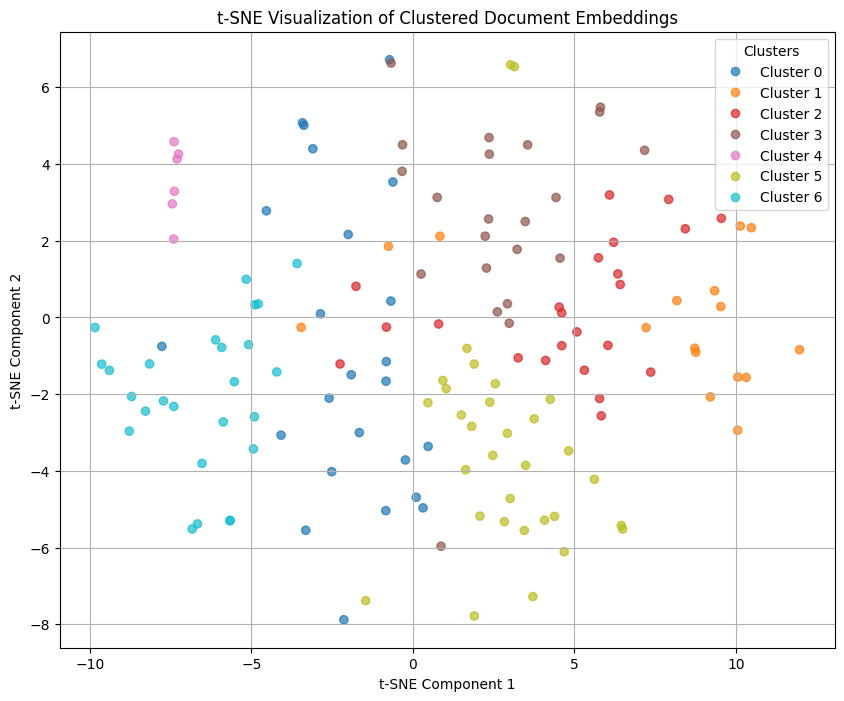

In [6]:
from sklearn.manifold import TSNE

# Perform t-SNE for visualization of clusters
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Plot the clustered embeddings using t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)

# Add a legend with cluster labels
legend_labels = [f'Cluster {i}' for i in range(optimal_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters")

# Add labels and title
plt.title('t-SNE Visualization of Clustered Document Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


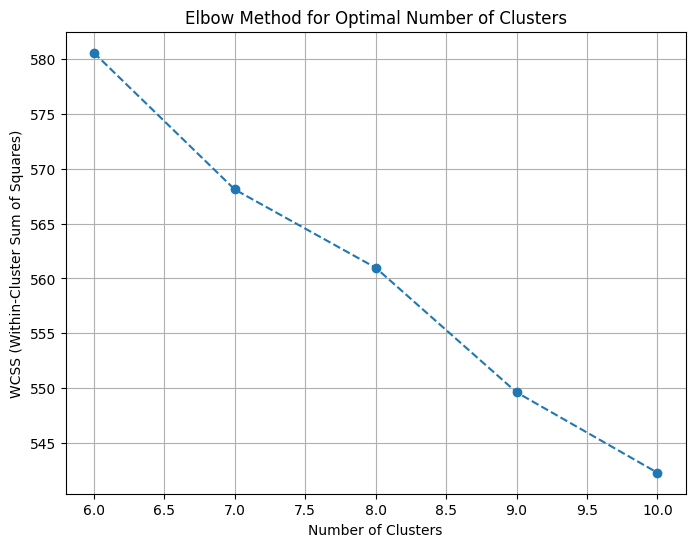

Clustered data saved successfully to outputs/clustered_document_embeddings.json


c:\Users\dionusia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\dionusia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


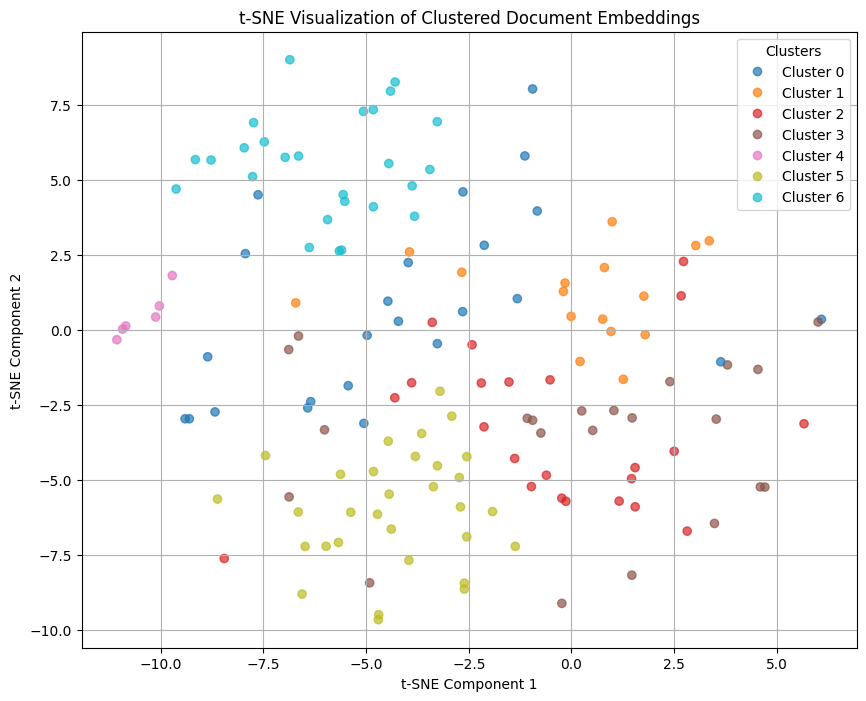

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Load the combined embeddings from the JSON file
embeddings_file_path = 'outputs/combined_document_embeddings.json'  # Replace with your file path
with open(embeddings_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the embeddings from the data
embeddings = np.array([entry['Combined_Embedding'] for entry in data])

# Step 1: Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
min_clusters = 6
max_clusters = 10

for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Step 2: Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Step 3: Choose the optimal number of clusters based on the Elbow Method
optimal_clusters = int(input("Based on the Elbow graph, please enter the optimal number of clusters: "))

# Step 4: Perform K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Step 5: Add the cluster labels to each document in the data
for i, entry in enumerate(data):
    entry['Cluster_Label'] = int(cluster_labels[i])

# Save the clustered data to a new JSON file
clustered_output_file_path = 'outputs/clustered_document_embeddings.json'  # Replace with your desired file path
with open(clustered_output_file_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print(f"Clustered data saved successfully to {clustered_output_file_path}")

# Step 6: Perform t-SNE for visualization of clusters
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Plot the clustered embeddings using t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)

# Add a legend with cluster labels
legend_labels = [f'Cluster {i}' for i in range(optimal_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters")

# Add labels and title
plt.title('t-SNE Visualization of Clustered Document Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import json

# Load the clustered data from the JSON file
clustered_file_path = 'outputs/clustered_document_embeddings.json'  # Replace with your file path
with open(clustered_file_path, 'r', encoding='utf-8') as f:
    clustered_data = json.load(f)

# Create a dictionary to store text for each cluster
cluster_texts = {}

# Step 1: Concatenate all text data (Title, Abstract, Keywords) for each cluster
for entry in clustered_data:
    cluster_label = entry['Cluster_Label']
    text = ' '.join(filter(None, [entry.get('Title', ''), entry.get('Abstract', ''), entry.get('Keywords', '')]))
    if cluster_label not in cluster_texts:
        cluster_texts[cluster_label] = []
    cluster_texts[cluster_label].append(text)

# Combine all texts for each cluster into a single document
for cluster_label in cluster_texts:
    cluster_texts[cluster_label] = ' '.join(cluster_texts[cluster_label])

# Step 2: Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(cluster_texts.values())
terms = vectorizer.get_feature_names_out()

# Step 3: Apply LDA to identify hidden topics within each cluster
lda = LatentDirichletAllocation(n_components=1, random_state=42)  # One topic per cluster
cluster_keywords = {}

for cluster_idx, cluster_label in enumerate(cluster_texts.keys()):
    lda.fit(X[cluster_idx])
    topic = lda.components_[0]
    top_indices = topic.argsort()[-10:][::-1]  # Get the top 10 words for the topic
    top_keywords = [terms[i] for i in top_indices]
    cluster_keywords[cluster_label] = top_keywords

# Step 4: Refine the keywords using TF-CDF to filter out common words
refined_cluster_keywords = {}

for cluster_idx, cluster_label in enumerate(cluster_texts.keys()):
    tf = X[cluster_idx].toarray().flatten()  # Term Frequency in the current cluster
    cdf = np.log(1 + X.toarray().sum(axis=0))  # Cluster Document Frequency across all clusters
    tf_cdf = tf * (1 / cdf)  # Calculate the TF-CDF score for each term

    # Filter the LDA keywords using TF-CDF scores to highlight distinct words
    refined_keywords = [word for word in cluster_keywords[cluster_label] if word in terms]
    top_refined_indices = [terms.tolist().index(word) for word in refined_keywords if word in terms]
    refined_top_keywords = sorted(top_refined_indices, key=lambda i: tf_cdf[i], reverse=True)[:10]
    refined_cluster_keywords[cluster_label] = [terms[i] for i in refined_top_keywords]

# Step 5: Display the refined most important words for each cluster
for cluster_label, keywords in refined_cluster_keywords.items():
    print(f'Cluster {cluster_label}: Refined Most Important Words - {", ".join(keywords)}')


Cluster 1: Refined Most Important Words - handwriting, font, recognition, character, handwritten, learning, chinese, model, based, text
Cluster 2: Refined Most Important Words - text, image, scene, images, recognition, models, model, detection, document, information
Cluster 3: Refined Most Important Words - end, recognition, signature, model, document, multi, performance, learning, based, models
Cluster 0: Refined Most Important Words - document, dataset, text, documents, data, question, models, image, information, learning
Cluster 4: Refined Most Important Words - documents, extraction, task, information, document, tasks, images, image, model, data
Cluster 5: Refined Most Important Words - document, table, layout, model, text, extraction, graph, information, data, recognition
Cluster 6: Refined Most Important Words - recognition, text, historical, dataset, competition, images, data, handwritten, documents, task


In [14]:
from collections import Counter

# Predefined categories with associated keywords
categories = {
    "Tables": {"table", "layout", "graph", "cell", "spreadsheet"},
    "Classification": {"classification", "category", "predict", "label", "classifier"},
    "Key Information Extraction": {"extraction", "task", "key", "information", "field"},
    "Optical Character Recognition": {"recognition", "text", "handwritten", "ocr", "character"},
    "Datasets": {"dataset", "data", "competition", "image", "documents"},
    "Document Layout Understanding": {"document", "layout", "structure", "format", "content"},
    "Others": set()  # To handle cases where none of the keywords match
}

# Refined cluster keywords from the previous analysis
cluster_keywords = {
    1: ["handwriting", "font", "recognition", "character", "handwritten", "learning", "chinese", "model", "based", "text"],
    2: ["text", "image", "scene", "images", "recognition", "models", "model", "detection", "document", "information"],
    3: ["end", "recognition", "signature", "model", "document", "multi", "performance", "learning", "based", "models"],
    0: ["document", "dataset", "text", "documents", "data", "question", "models", "image", "information", "learning"],
    4: ["documents", "extraction", "task", "information", "document", "tasks", "images", "image", "model", "data"],
    5: ["document", "table", "layout", "model", "text", "extraction", "graph", "information", "data", "recognition"],
    6: ["recognition", "text", "historical", "dataset", "competition", "images", "data", "handwritten", "documents", "task"]
}

# Function to calculate similarity scores between cluster keywords and categories
def calculate_similarity(cluster_keywords, category_keywords):
    overlap = len(set(cluster_keywords) & category_keywords)
    return overlap / len(category_keywords) if category_keywords else 0

# Dictionary to store the best-matching categories for each cluster
cluster_to_category = {}

# Step 3: Match each cluster to the predefined categories
for cluster_label, keywords in cluster_keywords.items():
    similarity_scores = {category: calculate_similarity(keywords, category_keywords) for category, category_keywords in categories.items()}
    sorted_categories = sorted(similarity_scores, key=similarity_scores.get, reverse=True)

    # Take the top 3 categories and if they don't match well, add "Others"
    top_categories = sorted_categories[:3] if similarity_scores[sorted_categories[0]] > 0 else ["Others"]
    cluster_to_category[cluster_label] = top_categories

# Step 4: Display the best matching categories for each cluster
for cluster_label, top_categories in cluster_to_category.items():
    print(f'Cluster {cluster_label}: Best Matching Categories - {", ".join(top_categories)}')


Cluster 1: Best Matching Categories - Optical Character Recognition, Tables, Classification
Cluster 2: Best Matching Categories - Optical Character Recognition, Key Information Extraction, Datasets
Cluster 3: Best Matching Categories - Optical Character Recognition, Document Layout Understanding, Tables
Cluster 0: Best Matching Categories - Datasets, Key Information Extraction, Optical Character Recognition
Cluster 4: Best Matching Categories - Key Information Extraction, Datasets, Document Layout Understanding
Cluster 5: Best Matching Categories - Tables, Key Information Extraction, Optical Character Recognition
Cluster 6: Best Matching Categories - Datasets, Optical Character Recognition, Key Information Extraction


In [15]:
import json

# Cluster to category mapping based on the refined analysis
cluster_to_category_mapping = {
    1: ["opticalCharacterRecognition", "layoutUnderstanding", "others"],
    2: ["keyInformationExtraction", "opticalCharacterRecognition", "datasets"],
    3: ["opticalCharacterRecognition", "classification", "keyInformationExtraction"],
    0: ["datasets", "layoutUnderstanding", "keyInformationExtraction"],
    4: ["keyInformationExtraction", "layoutUnderstanding", "datasets"],
    5: ["tables", "layoutUnderstanding", "keyInformationExtraction"],
    6: ["opticalCharacterRecognition", "datasets", "keyInformationExtraction"]
}

# Load the clustered data from the JSON file
clustered_file_path = 'outputs/clustered_document_embeddings.json'  # Replace with your file path
with open(clustered_file_path, 'r', encoding='utf-8') as f:
    clustered_data = json.load(f)

# Create the structured JSON format with the specified categories
categorized_data = {
    "tables": [],
    "classification": [],
    "keyInformationExtraction": [],
    "opticalCharacterRecognition": [],
    "datasets": [],
    "layoutUnderstanding": [],
    "others": []
}

# Organize documents into categories based on the cluster labels
for entry in clustered_data:
    cluster_label = entry['Cluster_Label']
    original_file_name = entry.get('ID', 'Unknown')  # Assuming 'ID' represents the original file name
    title = entry.get('Title', 'No Title')
    authors = entry.get('Authors', [])

    # Create the document entry for the category
    document_entry = {
        "originalFileName": original_file_name,
        "title": title,
        "authors": authors
    }

    # Determine the top category for this cluster, or place in "others" if no clear match is found
    top_category = cluster_to_category_mapping.get(cluster_label, ["others"])[0]
    categorized_data[top_category].append(document_entry)

# Save the organized JSON data to a new file
output_categorized_file_path = 'outputs/organized_categorized_documents.json'  # Use your desired file path
with open(output_categorized_file_path, 'w', encoding='utf-8') as f:
    json.dump(categorized_data, f, ensure_ascii=False, indent=4)

print(f"Organized categorized documents saved successfully to {output_categorized_file_path}")


Organized categorized documents saved successfully to outputs/organized_categorized_documents.json
